<a href="https://colab.research.google.com/github/ZalanBokor/Temalab/blob/main/Current_Best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed, Conv1D, MaxPooling1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from keras.callbacks import History
from keras.models import Model


In [183]:
!git clone https://github.com/ZalanBokor/Temalab.git
df = pd.read_csv('Temalab/SPX.csv')
relevant_columns = list(df)[2:8]
to_train = df[relevant_columns]
to_train ['Target'] = to_train['Adj Close']-to_train['Open']
#to_train ['Target'] = to_train['Target'].shift(-1)
train_dates = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='ignore')
to_train['Direction'] = [1 if to_train.Target[i]>0 else 0 for i in range(len(to_train))]
to_train['TargetNextClose'] = to_train['Adj Close'].shift(-1)
to_train.head(20)
train_dates = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='ignore')

fatal: destination path 'Temalab' already exists and is not an empty directory.


<ipython-input-183-9215d717110f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_train ['Target'] = to_train['Adj Close']-to_train['Open']


In [184]:
data_set = to_train.iloc[:, 0:9]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)
#data_set.describe()

,Open,High,Low,Close,Adj Close,Volume,Target,Direction,TargetNextClose
0,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,-14.030029,0,1399.420044
1,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-55.799927,0,1402.109985
2,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,2.689941,1,1403.449951
3,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1.339966,1,1441.469971
4,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,38.020020,1,1457.599976
5,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,16.130005,1,1438.560059
6,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000,-19.039917,0,1432.250000
7,1438.560059,1442.599976,1427.079956,1432.250000,1432.250000,974600000,-6.310059,0,1449.680054
8,1432.250000,1454.199951,1432.250000,1449.680054,1449.680054,1030400000,17.430054,1,1465.150024
9,1449.680054,1473.000000,1449.680054,1465.150024,1465.150024,1085900000,15.469970,1,1455.140015


2085.179932

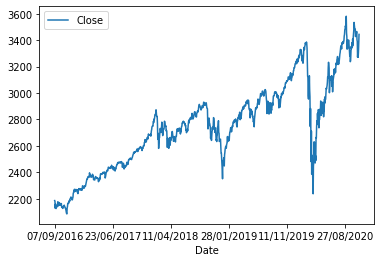

In [185]:
desired_columns = ['Date', 'Close']
desired_features = df[desired_columns]
desired_features.index = train_dates
desired_features = desired_features[int(len(desired_features)*0.8):]
_ = desired_features.plot(subplots=True)
original_max = to_train[int(len(to_train)*0.8):]['TargetNextClose'].max()
original_min = to_train[int(len(to_train)*0.8):]['TargetNextClose'].min()
original_min

In [186]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.2737761  0.27057492 0.26898593 ... 0.46760539 0.         0.24890249]
 [0.26891378 0.2627003  0.25471688 ... 0.32418956 0.         0.24982868]
 [0.24957547 0.24819899 0.2478316  ... 0.52501297 1.         0.25029005]
 ...
 [0.90693337 0.91082459 0.91093068 ... 0.56398323 1.         0.92711516]
 [0.92081332 0.93134079 0.93063129 ... 0.62877244 1.         0.95269095]
 [0.94514565 0.96478889 0.95465826 ... 0.64274691 1.                nan]]


In [187]:
X = []
window_dim = 30
for j in range(4):
    X.append([])
    for i in range(window_dim, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-window_dim:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[window_dim:,-1])
y=np.reshape(yi,(len(yi),1))

print('The shape of X is: ',X.shape)
print('The shape of y is: ',y.shape)

The shape of X is:  (5215, 30, 4)
The shape of y is:  (5215, 1)


In [188]:
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):int(len(X))-1]
y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):int(len(X))-1]
print('The shape of X_train is: ', X_train.shape)
print('The shape of X_test is: ',X_test.shape)
print('The shape of y_train is: ',y_train.shape)
print('The shape of y_test is: ',y_test.shape)

The shape of X_train is:  (4172, 30, 4)
The shape of X_test is:  (1042, 30, 4)
The shape of y_train is:  (4172, 1)
The shape of y_test is:  (1042, 1)


In [189]:
np.random.seed(10)


X_train = X_train.reshape((X_train.shape[0], 2, 15, 4))
X_test = X_test.reshape((X_test.shape[0], 2, 15, 4))


model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(2,15,4)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
adam = optimizers.Adam()
sgd = optimizers.SGD()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='auto')
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=100, epochs=100, shuffle=True, validation_split = 0.1, callbacks = [callback])

Epoch 1/100
38/38 [==============================] - 2s 21ms/step - loss: 0.0072 - val_loss: 4.6418e-04
Epoch 2/100
38/38 [==============================] - 0s 11ms/step - loss: 2.6312e-04 - val_loss: 7.5125e-04
Epoch 3/100
38/38 [==============================] - 0s 12ms/step - loss: 2.0543e-04 - val_loss: 5.3614e-04
Epoch 4/100
38/38 [==============================] - 0s 12ms/step - loss: 1.8783e-04 - val_loss: 3.2323e-04
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 1.7398e-04 - val_loss: 3.1641e-04
Epoch 6/100
38/38 [==============================] - 0s 12ms/step - loss: 1.5402e-04 - val_loss: 2.5384e-04
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 1.3637e-04 - val_loss: 2.2257e-04
Epoch 8/100
38/38 [==============================] - 0s 12ms/step - loss: 1.1542e-04 - val_loss: 2.5034e-04
Epoch 9/100
38/38 [==============================] - 1s 13ms/step - loss: 1.0168e-04 - val_loss: 2.5475e-04
Epoch 10/100
38/38 [============

In [190]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 2, 15, 64)        320       
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 2, 7, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 2, 448)           0         
 stributed)                                                      
                                                                 
 lstm_9 (LSTM)               (None, 50)                99800     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                     

In [191]:
y_pred = model.predict(X_test)
rmse=np.sqrt(np.mean(((y_pred- y_test)**2)))
rmse

33/33 [==============================] - 1s 6ms/step


0.020447196767806316

In [192]:
window_size = 30  
i = 0
moving_average_baseline = []
while i < len(y_test) - window_size + 1:
    window = y_test[i : i + window_size]
    window_average = (sum(window) / window_size)
    moving_average_baseline.append(window_average)
    i += 1

moving_average_baseline
y_test_to_compare = y_test[29:]

rmse_moving_average=np.sqrt(np.mean(((moving_average_baseline- y_test_to_compare)**2)))
rmse_moving_average

0.034978523301910876

In [193]:
mae_moving_average = np.mean(np.abs(y_test_to_compare - moving_average_baseline))
mae_moving_average

0.023039559630887902

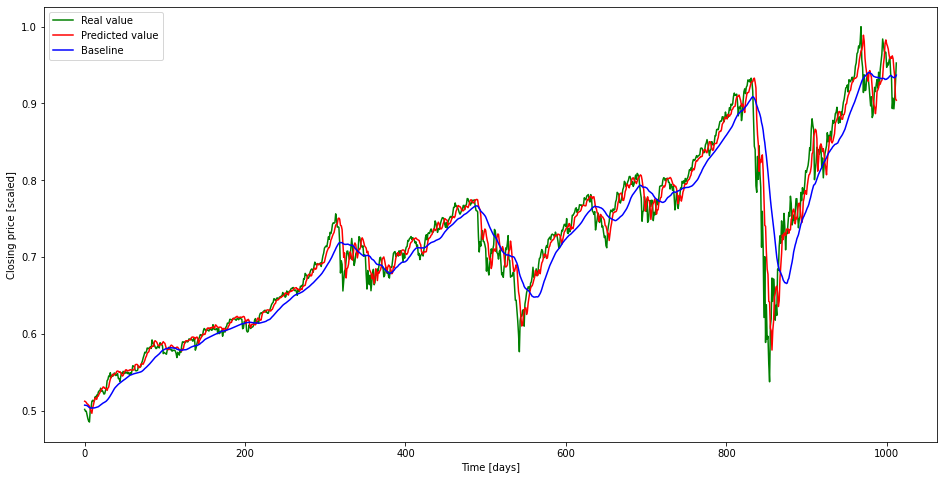

In [201]:
naive_baseline = np.roll(y_test, 1)
naive_baseline = naive_baseline[1:]
y_test_to_compare_with_naive = y_test[1:]
rmse_naive = np.sqrt(np.mean(((naive_baseline- y_test_to_compare_with_naive)**2)))
plt.figure(figsize=(16,8))
plt.plot(y_test_to_compare, color = 'green', label = 'Real value')
plt.plot(y_pred_to_compare, color = 'red', label = 'Predicted value')
plt.plot(moving_average_baseline, color = 'blue', label = 'Baseline')
plt.xlabel("Time [days]")
plt.ylabel("Closing price [scaled]")
plt.legend()
plt.show()


In [195]:
rmse_naive


0.012093777576641238

In [196]:
#naive_baseline = naive_baseline = naive_baseline[:int(len(naive_baseline))-1]
mae_naive = np.mean(np.abs(y_test_to_compare_with_naive - naive_baseline))
mae_naive

0.0069870331717716

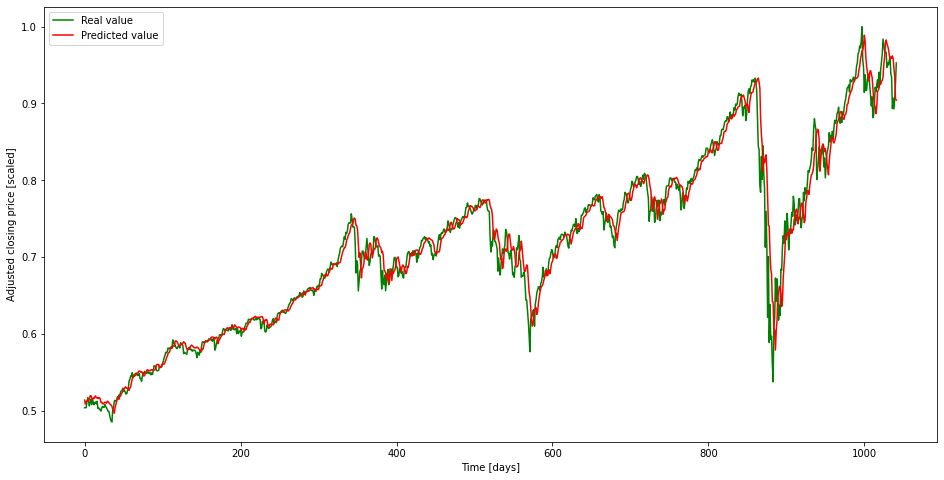

In [197]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'green', label = 'Real value')
plt.plot(y_pred, color = 'red', label = 'Predicted value')
plt.xlabel("Time [days]")
plt.ylabel("Adjusted closing price [scaled]")
plt.legend()
plt.show()

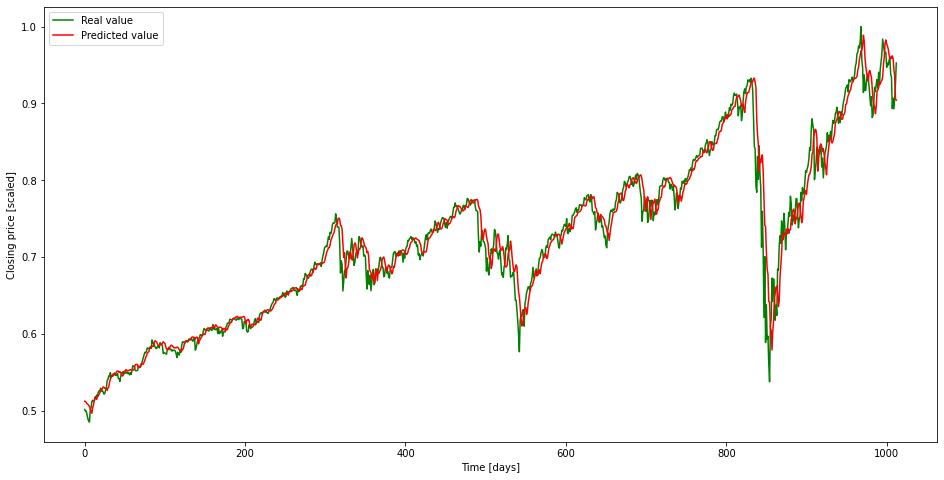

In [198]:
naive_baseline = np.roll(y_test, 0)
plt.figure(figsize=(16,8))
y_pred_to_compare = y_pred[29:]
plt.plot(y_test_to_compare, color = 'green', label = 'Real value')
plt.plot(y_pred_to_compare, color = 'red', label = 'Predicted value')
#plt.plot(moving_average_baseline, color = 'blue', label = 'Baseline')
plt.xlabel("Time [days]")
plt.ylabel("Closing price [scaled]")
plt.legend()
plt.show()



In [199]:
rmse_small=np.sqrt(np.mean(((y_pred_to_compare- y_test_to_compare)**2)))
rmse_small


0.020694249691625356

In [200]:
mae_small = np.mean(np.abs(y_test_to_compare - y_pred_to_compare))
mae_small

0.012845909102595537